In [1]:
import os
os.chdir("..")

<h3> Load Libraries </h3>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.metrics import get_error_stats
from production.plots import plot_adaptive_evolution
from production.utils import add_return_periods

<h3> Preprocess data </h3>

In [3]:
watershed_name = "Trinity"

In [ ]:
watershed = Preprocessor(config_path = f"/workspaces/Importance-Sampling-for-SST/data/0_source/{watershed_name}/config.json", 
                       output_folder = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}")
watershed.run()

In [4]:
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")

<h3> Full Monte Samples </h3>

In [ ]:
#If doing 2,000 RP over 50 realizations (1 mil total simulations)
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=20_000,
    num_rep=50,
)

fullmonte_samples = sampler.sample(data = watershed)

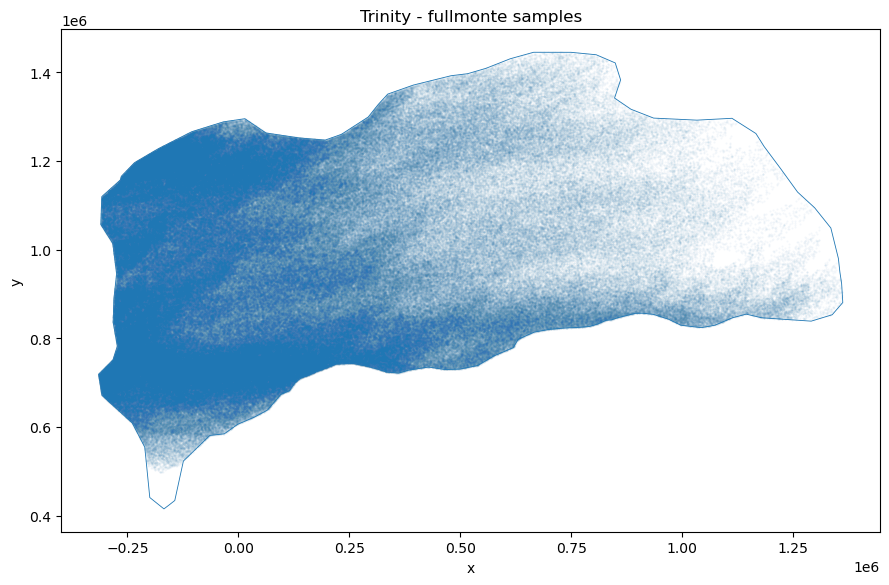

In [6]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(fullmonte_samples.newx, fullmonte_samples.newy, s=0.2, alpha=0.05, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - fullmonte samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [7]:
fullmonte_depths = StormDepthProcessor(watershed).run(fullmonte_samples, n_jobs=-1)

In [12]:
#Save
fullmonte_depths.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

In [36]:
#Read
fullmonte_depths = pd.read_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

<h3> Importance Sampling - Truncated Normals </h3>

In [ ]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"],
    "sd_y": watershed.watershed_stats["range_y"]*0.5,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=7_000,
    num_rep=50,
    seed=42,
)

TruncNorm_samples = sampler.sample(data = watershed)

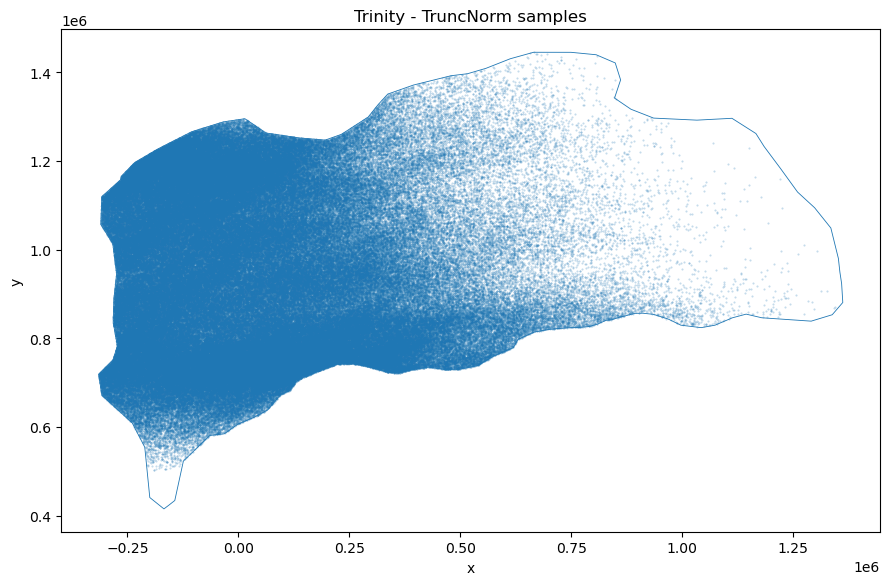

In [15]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(TruncNorm_samples.newx, TruncNorm_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - TruncNorm samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [16]:
TruncNorm_depths = StormDepthProcessor(watershed).run(TruncNorm_samples, n_jobs=-1)

<h3> Importance Sampling - Gaussian Copula </h3>

In [27]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"],
    "sd_y": watershed.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=7000,
    num_rep=50,
)

copula_samples = sampler.sample(data = watershed)

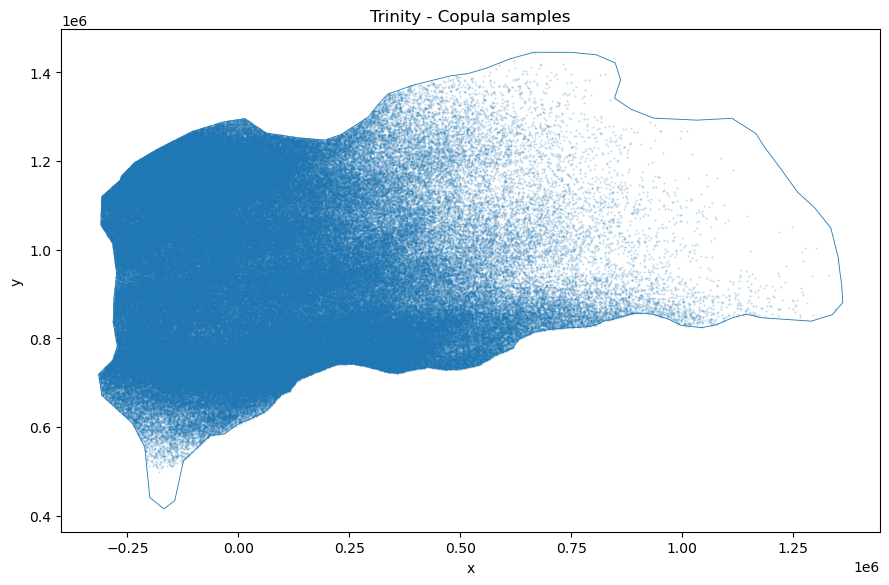

In [28]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [29]:
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

<h3> Importance Sampling - Mixture</h3>

In [ ]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.3,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.3,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=7_000,
    num_rep=50,
    seed=42,
)

mixture_samples = sampler.sample(data = watershed)

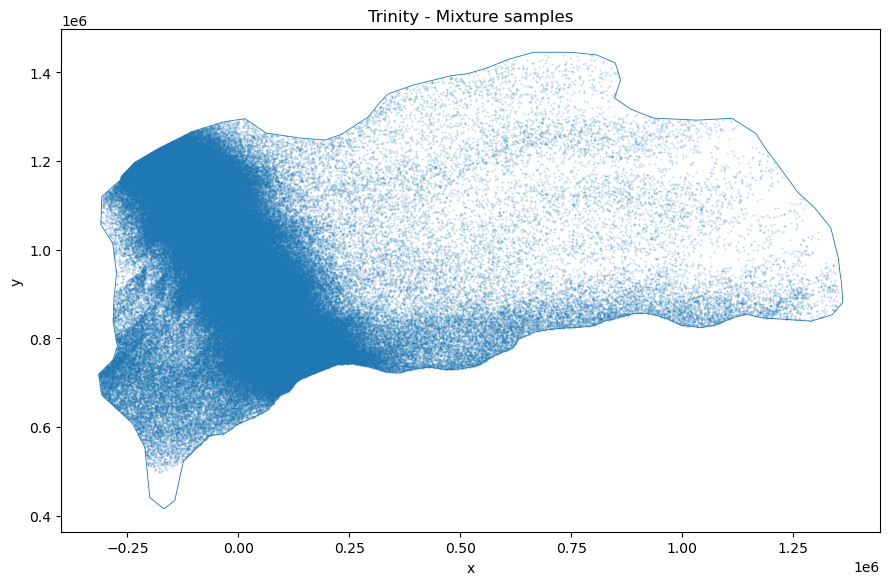

In [25]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(mixture_samples.newx, mixture_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Mixture samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [26]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

<h3> Importance Sampling - Adaptive Mixture </h3>

In [ ]:
params = AdaptParams(
    # Narrow component starts around watershed centroid
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"]*0.5,
    sd_y_n=watershed.watershed_stats["range_y"]*0.5,

    # Wide component starts around full domain centroid
    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    # Optional extras
    mix=0.5,            # initial mixture weight for narrow
    rho_n=-0.7,         # correlation in narrow copula
    rho_w=0.5,          # correlation in wide copula
)

sampler = AdaptiveMixtureSampler(
    precip_cube=watershed.cumulative_precip,
    storm_centers=watershed.storm_centers,
    watershed_gdf=watershed.watershed_gdf,
    domain_gdf=watershed.domain_gdf,
    params=params,
    seed=42,
)

In [ ]:
history = sampler.adapt(num_iterations=10, samples_per_iter=500)
print(history)

In [ ]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [ ]:
#Do final N required samples from the final distributions
samples = sampler.sample_final(n=100_000, with_depths=True)
print(samples.head()) 